In [1]:
import pandas as pd
file_path = 'Case Study Data - Read Only.xlsx'
df = pd.ExcelFile(file_path)
df = df.parse('Sheet1')

Epoch 1/100


C:\Users\Amolo Washington\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2982 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2458 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1787 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0831
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0512 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0760 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0702 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0593     
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0490      
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0548
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383     
Epoch 16/100
6/6 ━━━━━━

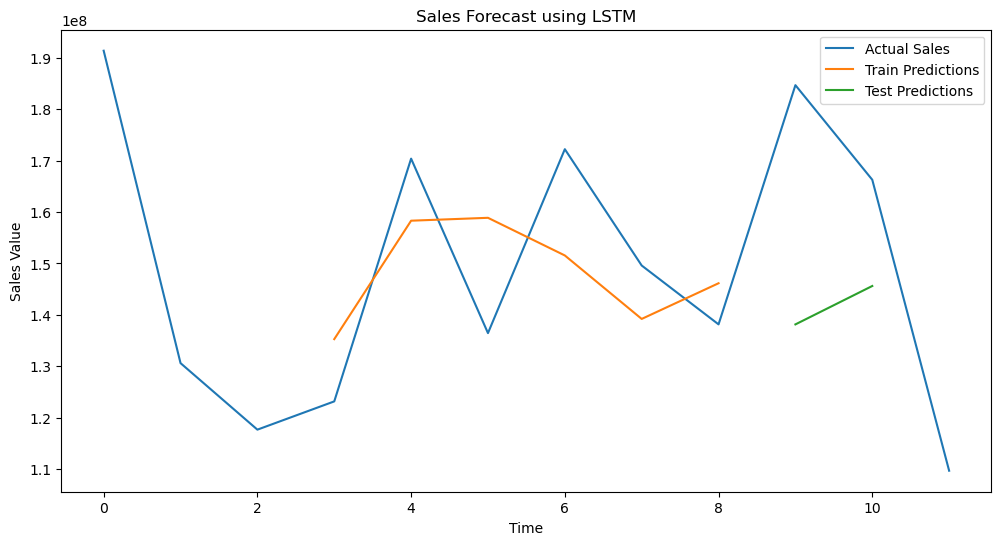

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

df['DATE'] = pd.to_datetime(df['DATE'])
df['Month-Year'] = df['DATE'].dt.strftime('%Y-%m')
df['Value'] = df['QUANTITY'] * df['UNIT PRICE']
monthly_sales = df.groupby('Month-Year').agg({'Value': 'sum'}).reset_index()

data = monthly_sales['Value'].values
data = data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 3
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=1, epochs=100, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, test_predict)
rmse = np.sqrt(mean_squared_error(y_test, test_predict))
accuracy = 100 - (mae / np.mean(y_test) * 100)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(12, 6))

plt.plot(scaler.inverse_transform(scaled_data), label='Actual Sales')

train_plot_range = np.arange(time_step, len(train_predict) + time_step)
plt.plot(train_plot_range, train_predict, label='Train Predictions')

test_plot_range = np.arange(len(train_predict) + time_step, len(train_predict) + time_step + len(test_predict))
plt.plot(test_plot_range, test_predict, label='Test Predictions')

plt.title('Sales Forecast using LSTM')
plt.xlabel('Time')
plt.ylabel('Sales Value')
plt.legend()
plt.show()